In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facial-expression-recognitionferchallenge/Submission.csv
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.bib
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/README
/kaggle/input/haarcascade-frontalface/haarcascade_frontalface_default.xml


In [5]:
import sys, os
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils

In [6]:


data = pd.read_csv("/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv")
data.shape

(35887, 3)

In [7]:
data.head(9)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [8]:
data.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [9]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


In [14]:
X_train,train_y,X_test,test_y=[],[],[],[]

for index, row in data.iterrows():
    val=row['pixels'].split(" ")
    try:
        if 'Training' in row['Usage']:
           X_train.append(np.array(val,'float32'))
           train_y.append(row['emotion'])
        elif 'PublicTest' in row['Usage']:
           X_test.append(np.array(val,'float32'))
           test_y.append(row['emotion'])
    except:
        print(f"error occured at index :{index} and row:{row}")


num_features = 64
num_labels = 7
batch_size = 64
epochs = 60
width, height = 48, 48


X_train = np.array(X_train,'float32')
train_y = np.array(train_y,'float32')
X_test = np.array(X_test,'float32')
test_y = np.array(test_y,'float32')

train_y=np_utils.to_categorical(train_y, num_classes=num_labels)
test_y=np_utils.to_categorical(test_y, num_classes=num_labels)

#cannot produce
#normalizing data between oand 1
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)

X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)

X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

# print(f"shape:{X_train.shape}")
##designing the cnn
#1st convolution layer
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

#2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

#3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Flatten())

#fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_labels, activation='softmax'))

# model.summary()

#Compliling the model
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

#Training the model
history=model.fit(X_train, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, test_y),
          shuffle=True)
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")


Epoch 1/60
449/449 [==============================] - 6s 14ms/step - loss: 1.7203 - accuracy: 0.3165 - val_loss: 1.5457 - val_accuracy: 0.3923
Epoch 2/60
449/449 [==============================] - 6s 13ms/step - loss: 1.4649 - accuracy: 0.4323 - val_loss: 1.4029 - val_accuracy: 0.4561
Epoch 3/60
449/449 [==============================] - 6s 14ms/step - loss: 1.3460 - accuracy: 0.4824 - val_loss: 1.3165 - val_accuracy: 0.4957
Epoch 4/60
449/449 [==============================] - 6s 14ms/step - loss: 1.2702 - accuracy: 0.5176 - val_loss: 1.2631 - val_accuracy: 0.5113
Epoch 5/60
449/449 [==============================] - 6s 14ms/step - loss: 1.2177 - accuracy: 0.5376 - val_loss: 1.2528 - val_accuracy: 0.5272
Epoch 6/60
449/449 [==============================] - 6s 13ms/step - loss: 1.1654 - accuracy: 0.5537 - val_loss: 1.1668 - val_accuracy: 0.5520
Epoch 7/60
449/449 [==============================] - 6s 13ms/step - loss: 1.1303 - accuracy: 0.5723 - val_loss: 1.1407 - val_accuracy: 0.5695

Epoch 58/60
449/449 [==============================] - 6s 13ms/step - loss: 0.2103 - accuracy: 0.9271 - val_loss: 1.8838 - val_accuracy: 0.6032
Epoch 59/60
449/449 [==============================] - 6s 13ms/step - loss: 0.1985 - accuracy: 0.9310 - val_loss: 1.9903 - val_accuracy: 0.6119
Epoch 60/60
449/449 [==============================] - 6s 13ms/step - loss: 0.2060 - accuracy: 0.9276 - val_loss: 1.9446 - val_accuracy: 0.6055


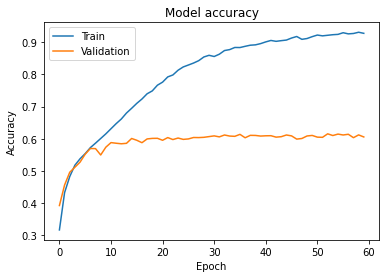

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history["val_accuracy"])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history["val_loss"])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()